## Notebook for interpreting ML for $\sigma$ through SHAP

#### Model: LightGBM

#### Splitting: Random

**Created on 21st September, 2022; modified on 3rd January; remodified on 21st April, 2023 (new color scheme)**

In [1]:
import warnings
warnings.filterwarnings('ignore')
#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
import seaborn as sns
import pandas as pd
import numpy as np
#import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, LassoCV, \
    RidgeClassifier, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR, SVC
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel, \
RationalQuadratic, ExpSineSquared, DotProduct
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, \
precision_score, auc
import sys
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import pickle
#import optuna
import lightgbm as lgb
from lightgbm import LGBMRegressor
import shap

In [2]:
%%bash
pwd
ls -ltr

/Users/riteshkumar/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/ionic-conductivity_2.0/lgbm_08-29-22/multi-comp/2D-feat/random-split_avg-mw
total 37176
-rw-r--r--@ 1 riteshkumar  staff   2653535 Dec 12 10:32 train_multi_comp_2d.csv
-rw-r--r--@ 1 riteshkumar  staff    333059 Dec 12 10:32 test_multi_comp_2d.csv
-rw-r--r--@ 1 riteshkumar  staff    330545 Dec 12 10:32 val_multi_comp_2d.csv
-rw-r--r--@ 1 riteshkumar  staff   3208393 Dec 12 11:16 fgrp_2d_feat_all_multi_comp.csv
-rw-r--r--@ 1 riteshkumar  staff    113130 Jan  2 11:50 calc-avg-mw.ipynb
-rw-r--r--  1 riteshkumar  staff   2512797 Jan  2 11:50 new_train_multi_comp_2d.csv
-rw-r--r--  1 riteshkumar  staff    313049 Jan  2 11:50 new_val_multi_comp_2d.csv
-rw-r--r--  1 riteshkumar  staff    315580 Jan  2 11:50 new_test_multi_comp_2d.csv
-rw-r--r--  1 riteshkumar  staff       436 Jan  2 12:05 best-paramters_lgbr_cv_10.txt
-rw-r--r--@ 1 riteshkumar  staff       436 Jan  2 13:43 best-paramters_lgbr_cvs_10.txt
-rw-

In [3]:
val_df = pd.read_csv('new_val_multi_comp_2d.csv')
train_df = pd.read_csv('new_train_multi_comp_2d.csv')
test_df = pd.read_csv('new_test_multi_comp_2d.csv')
train_df

,solv_comb_sm,salt_smiles,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,...,fr_func_grp_41_salt,fr_func_grp_42_salt,fr_func_grp_43_salt,num_heavy_atom_salt,num_rot_bond_salt,mw_salt,conc_salt,temperature,mol_wt_solv_avg,conductivity_log
0,CCOCCOCCF.O=C1OCCO1,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,144.964181,1.0000,15.0,112.053001,1.887070
1,CC1COC(=O)O1,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,144.964181,0.4800,-0.2,102.031694,1.077993
2,CC1COC(=O)O1.CCOC(=O)OCC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,144.964181,0.4800,-29.5,110.047344,0.362224
3,COCCOC.COCCOCC(F)(F)C(F)F,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,16,2,279.917842,1.0000,40.0,140.064886,1.857859
4,CC1COC(=O)O1,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,144.964181,1.7000,25.0,102.031694,1.629241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8161,FC(F)C(F)(F)COC(F)(F)C(F)F.COC(=O)OCC(F)(F)F.O...,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,144.964181,1.2000,25.0,159.349521,1.098612
8162,CCCCCCCCCC1COC(=O)O1,[Li+].C(F)(F)(F)S(=O)(=O)[O-],0,0,0,0,0,0,0,0,...,0,0,0,9,0,148.952573,0.3000,25.0,214.156895,-3.028255
8163,COCCOCCOCCOCCOC,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,16,2,279.917842,1.2700,30.0,222.146724,1.182280
8164,CC1COC(=O)O1.CCOC(=O)OCC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,144.964181,0.6524,59.0,110.047344,2.515274


In [4]:
X_train = train_df.iloc[:,2:-1]
y_train = train_df.iloc[:,-1]

X_test = test_df.iloc[:,2:-1]
y_test = test_df.iloc[:,-1]

X_val = val_df.iloc[:,2:-1]
y_val = val_df.iloc[:,-1]

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_train_std = pd.DataFrame(X_train_std, columns=X_train.columns)
X_test_std  = std_scale.transform(X_test)
X_test_std = pd.DataFrame(X_test_std, columns=X_train.columns)
X_val_std  = std_scale.transform(X_val)
X_val_std = pd.DataFrame(X_val_std, columns=X_train.columns)

X_train_ = np.array(X_train_std)
X_val_ = np.array(X_val_std)
X_test_ = np.array(X_test_std)

In [7]:
# params = {"lambda_l1": 0.00619635818901381,
#     "lambda_l2": 0.8939337698718999,
#     "num_leaves": 64,
#     "num_iterations": 371,
#     "max_depth": 4,
#     "max_bin": 43,
#     "feature_fraction": 0.9864992961949246,
#     "bagging_fraction": 0.6406930279315276,
#     "bagging_freq": 1,
#     "min_data_in_leaf": 80,
#     "min_gain_to_split": 0.6653703291808284,
#     "learning_rate": 0.3839698208116706,
#     "min_sum_hessian_in_leaf": 0.8958861901397117}

In [ ]:
# R2_train_array = []; R2_val_array = []
# rmse_train_array = []; rmse_val_array = []
# model = []
# start = 42
# end = 42
# for i in range(start, end+1):
#     print("counter for cv split: ", i)
#     kf = KFold(n_splits = 5, random_state = i, shuffle = True)
#     lgb = LGBMRegressor(**params)
#     for train_ind, test_ind in kf.split(X_train_):
#         X_train_cv, y_train_cv = X_train_[train_ind,:], y_train[train_ind]
#         X_test_cv, y_test_cv = X_train_[test_ind,:], y_train[test_ind]
#         lgb.fit(X_train_cv, y_train_cv)
#     y_pred_train = lgb.predict(X_train_)
#     y_pred_val = lgb.predict(X_val_)
#     rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
#     rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
#     R2_train = r2_score(y_train, y_pred_train)
#     R2_val = r2_score(y_val, y_pred_val)
#     rmse_train_array.append(rmse_train)
#     rmse_val_array.append(rmse_val)
#     R2_train_array.append(R2_train)
#     R2_val_array.append(R2_val)
#     print(rmse_train, rmse_val)
#     model.append(lgb)

In [5]:
lgb = pickle.load(open("lgbm_cond_multi_random_scaled_32.pkl","rb"))
lgb

LGBMRegressor(bagging_fraction=0.8382369376184493, bagging_freq=1,
              feature_fraction=0.627407263960409,
              lambda_l1=0.0010073636544338724, lambda_l2=9.827165847041067,
              learning_rate=0.7688547755317213, max_bin=41, max_depth=3,
              metric='root_mean_squared_error', min_data_in_leaf=9,
              min_gain_to_split=0.15986671177346395,
              min_sum_hessian_in_leaf=0.7844630197798843, num_iterations=452,
              num_leaves=20, objective='regression')

In [6]:
y_pred_train = lgb.predict(X_train_)
y_pred_val = lgb.predict(X_val_)
y_pred_test = lgb.predict(X_test_)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
R2_train = r2_score(y_train, y_pred_train)
R2_val = r2_score(y_val, y_pred_val)
R2_test = r2_score(y_test, y_pred_test)

print("RMSE for train / validation / test: {} / {} / {}".format(rmse_train, rmse_val, rmse_test))
print("R2 for train / validation / test: {} / {} / {}".format(R2_train, R2_val, R2_test))

RMSE for train / validation / test: 0.3709278421124791 / 0.47237768615022313 / 0.4973194808819298
R2 for train / validation / test: 0.9516869317668989 / 0.919645795921358 / 0.918422900913513


**Parity plot for trained model**

In [7]:
y_true_val = val_df['conductivity_log']
y_true_test = test_df['conductivity_log']

In [8]:
def plot_parity_two(y_true_1, y_pred_1, y_true_2, y_pred_2, file_name=None):
    """1st index: test set
    2nd index: validation set"""
    # y_true_1 = df_true_1['IE']
    # y_true_2 = df_true_2['IE']
    # y_pred_1 = df_pred_1['IE']
    # y_pred_2 = df_pred_2['IE']
    # y_pred_unc_1 = df_pred_1['IE_ensemble_uncal_var']
    # y_pred_unc_2 = df_pred_2['IE_ensemble_uncal_var']
    
    axmin_1 = min(min(y_true_1), min(y_pred_1)) - 0.1*(max(y_true_1)-min(y_true_1))
    axmin_2 = min(min(y_true_2), min(y_pred_2)) - 0.1*(max(y_true_2)-min(y_true_2))
    axmax_1 = max(max(y_true_1), max(y_pred_1)) + 0.1*(max(y_true_1)-min(y_true_1))
    axmax_2 = max(max(y_true_2), max(y_pred_2)) + 0.1*(max(y_true_2)-min(y_true_2))
    axmin = min(axmin_1, axmin_2)
    axmax = max(axmax_1, axmax_2)
    
    mae_1 = mean_absolute_error(y_true_1, y_pred_1)
    mae_2 = mean_absolute_error(y_true_2, y_pred_2)
    rmse_1 = mean_squared_error(y_true_1, y_pred_1, squared=False)
    rmse_2 = mean_squared_error(y_true_2, y_pred_2, squared=False)
    r2_1 = r2_score(y_true_1, y_pred_1)
    r2_2 = r2_score(y_true_2, y_pred_2)
    
    plt.plot([axmin, axmax], [axmin, axmax], '--k')

    plt.errorbar(y_true_1, y_pred_1, yerr=None, linewidth=0, marker='o', markeredgecolor='w', alpha=1, elinewidth=1, label='R$^2$ (test): {0:.3f}'.format(r2_1))
    plt.errorbar(y_true_2, y_pred_2, yerr=None, linewidth=0, marker='o', markeredgecolor='w', alpha=1, elinewidth=1, label='R$^2$ (validation): {0:.3f}'.format(r2_2))
    
    plt.xlim((axmin, axmax))
    plt.ylim((axmin, axmax))
    
    ax = plt.gca()
    ax.set_aspect('equal')
    
    # at = AnchoredText(
    # f"MAE (val) = {mae_1:.2f}\nRMSE (val) = {rmse_1:.2f}\nR$^2$ (val) = {r2_1:.2f}", prop=dict(size=10), frameon=True, loc='upper left')
    # at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    # ax.add_artist(at)

    # at2 = AnchoredText(
    # f"MAE (test) = {mae_2:.2f}\nRMSE (test) = {rmse_2:.2f}\nR$^2$ (test) = {r2_2:.2f}", prop=dict(size=10), frameon=True, loc='lower right')
    # at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    # ax.add_artist(at2)
    
    plt.xlabel('True log$\sigma$(mS/cm)')
    plt.ylabel('ML-predicted log$\sigma$(mS/cm)')
    plt.legend()
    
    if file_name == None:
        plt.show()
    else:
        plt.savefig(file_name, dpi=300)
    
    return

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


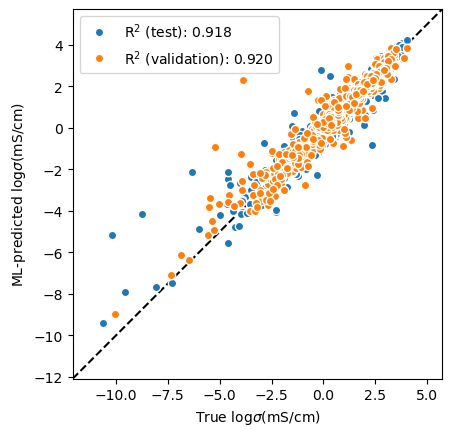

In [11]:
plot_parity_two(y_true_test, y_pred_test, y_true_val, y_pred_val, file_name='lgbm_split_freq2_parity.eps')

In [9]:
df_all = pd.concat([train_df, val_df, test_df], axis=0, ignore_index=True)
df_all

,solv_comb_sm,salt_smiles,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,...,fr_func_grp_41_salt,fr_func_grp_42_salt,fr_func_grp_43_salt,num_heavy_atom_salt,num_rot_bond_salt,mw_salt,conc_salt,temperature,mol_wt_solv_avg,conductivity_log
0,CCOCCOCCF.O=C1OCCO1,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,144.964181,1.000000,15.00,112.053001,1.887070
1,CC1COC(=O)O1,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,144.964181,0.480000,-0.20,102.031694,1.077993
2,CC1COC(=O)O1.CCOC(=O)OCC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,144.964181,0.480000,-29.50,110.047344,0.362224
3,COCCOC.COCCOCC(F)(F)C(F)F,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,16,2,279.917842,1.000000,40.00,140.064886,1.857859
4,CC1COC(=O)O1,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,144.964181,1.700000,25.00,102.031694,1.629241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10191,CC1CCCO1.O=C1OCCO1.CC1COC(=O)O1,[Li+].F[As-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,188.912016,1.000000,-30.00,92.040301,1.266948
10192,C1COB(OCCOB2OCCCO2)OC1,[Li+].[O-]Cl(=O)(=O)=O,0,0,0,2,0,0,0,0,...,0,0,0,6,0,98.949060,1.000000,30.00,230.113299,-8.727914
10193,CC1COC(=O)O1.CCOC(=O)OCC,CC[N+](CC)(CC)CC.F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,1,16,0,144.964181,1.160764,10.00,110.047344,2.120264
10194,COCCOCCOCCOCCOC,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,16,2,279.917842,2.347062,50.04,222.146724,1.079429


In [10]:
X_all = df_all.iloc[:,2:-1]

In [11]:
model = lgb
explainerModel = shap.TreeExplainer(model = model)
shap_values = explainerModel.shap_values(X_all)

In [12]:
## save the SHAP values
cols_X = X_all.columns
cols_shap = [('shap_' + cols_X[i]) for i in range(len(cols_X))]
shap_df = pd.DataFrame(shap_values)
shap_df.columns = cols_shap
# shap_df.to_csv('shap_values_all.csv', index=False)
shap_df

,shap_fr_func_grp_1_solv,shap_fr_func_grp_2_solv,shap_fr_func_grp_3_solv,shap_fr_func_grp_4_solv,shap_fr_func_grp_5_solv,shap_fr_func_grp_6_solv,shap_fr_func_grp_7_solv,shap_fr_func_grp_8_solv,shap_fr_func_grp_9_solv,shap_fr_func_grp_10_solv,...,shap_fr_func_grp_40_salt,shap_fr_func_grp_41_salt,shap_fr_func_grp_42_salt,shap_fr_func_grp_43_salt,shap_num_heavy_atom_salt,shap_num_rot_bond_salt,shap_mw_salt,shap_conc_salt,shap_temperature,shap_mol_wt_solv_avg
0,0.0,0.0,0.0,0.007764,-0.004916,0.0,0.0,0.0,0.0,-0.074328,...,0.0,0.000484,-0.000652,-0.075249,-1.109997,-0.057212,-0.481536,0.766027,2.996862,-1.173483
1,0.0,0.0,0.0,0.015316,-0.004852,0.0,0.0,0.0,0.0,-0.017630,...,0.0,0.000469,-0.000652,-0.071340,-1.035911,-0.044111,-0.453246,0.501433,-0.040492,-1.932523
2,0.0,0.0,0.0,0.015883,-0.064420,0.0,0.0,0.0,0.0,-0.107301,...,0.0,0.000525,-0.000665,-0.111118,-0.969859,-0.044266,-0.434851,0.432409,-3.188022,-1.809094
3,0.0,0.0,0.0,0.006469,-0.004848,0.0,0.0,0.0,0.0,0.289949,...,0.0,0.000484,-0.000652,-0.075249,-0.852873,0.314416,-0.388940,0.691475,3.080038,-1.040979
4,0.0,0.0,0.0,0.008195,-0.004852,0.0,0.0,0.0,0.0,-0.031258,...,0.0,0.000469,-0.000652,-0.076414,-1.098386,-0.032519,-0.538930,0.023960,3.120000,-1.380158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10191,0.0,0.0,0.0,0.016085,-0.064420,0.0,0.0,0.0,0.0,0.057050,...,0.0,0.000525,-0.000665,-0.111118,-0.923143,-0.092459,-0.465105,-0.056634,-3.295919,-2.027226
10192,0.0,0.0,0.0,0.276320,-0.004930,0.0,0.0,0.0,0.0,-0.304546,...,0.0,0.000469,-0.000464,-0.071340,-0.830804,-0.048766,-0.450450,0.854792,2.950397,-1.127519
10193,0.0,0.0,0.0,0.008546,-0.004852,0.0,0.0,0.0,0.0,-0.002600,...,0.0,0.000469,-0.000652,0.373356,-1.087090,-0.032519,-0.657835,0.444955,2.906924,-1.227679
10194,0.0,0.0,0.0,0.006173,-0.004702,0.0,0.0,0.0,0.0,0.287982,...,0.0,0.000484,-0.000652,-0.076414,-0.841110,0.207715,-0.461243,-0.465549,2.933326,-0.804249


In [13]:
comb_df = pd.concat([X_all,shap_df], axis=1)
comb_df

,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,fr_func_grp_9_solv,fr_func_grp_10_solv,...,shap_fr_func_grp_40_salt,shap_fr_func_grp_41_salt,shap_fr_func_grp_42_salt,shap_fr_func_grp_43_salt,shap_num_heavy_atom_salt,shap_num_rot_bond_salt,shap_mw_salt,shap_conc_salt,shap_temperature,shap_mol_wt_solv_avg
0,0,0,0,0,0,0,0,0,0,2,...,0.0,0.000484,-0.000652,-0.075249,-1.109997,-0.057212,-0.481536,0.766027,2.996862,-1.173483
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.000469,-0.000652,-0.071340,-1.035911,-0.044111,-0.453246,0.501433,-0.040492,-1.932523
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.000525,-0.000665,-0.111118,-0.969859,-0.044266,-0.434851,0.432409,-3.188022,-1.809094
3,0,0,0,0,0,0,0,0,0,4,...,0.0,0.000484,-0.000652,-0.075249,-0.852873,0.314416,-0.388940,0.691475,3.080038,-1.040979
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.000469,-0.000652,-0.076414,-1.098386,-0.032519,-0.538930,0.023960,3.120000,-1.380158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10191,0,0,0,0,0,0,0,0,0,1,...,0.0,0.000525,-0.000665,-0.111118,-0.923143,-0.092459,-0.465105,-0.056634,-3.295919,-2.027226
10192,0,0,0,2,0,0,0,0,0,0,...,0.0,0.000469,-0.000464,-0.071340,-0.830804,-0.048766,-0.450450,0.854792,2.950397,-1.127519
10193,0,0,0,0,0,0,0,0,0,0,...,0.0,0.000469,-0.000652,0.373356,-1.087090,-0.032519,-0.657835,0.444955,2.906924,-1.227679
10194,0,0,0,0,0,0,0,0,0,5,...,0.0,0.000484,-0.000652,-0.076414,-0.841110,0.207715,-0.461243,-0.465549,2.933326,-0.804249


In [35]:
comb_df['conductivity_log'] = df_all['conductivity_log']
comb_df

,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,fr_func_grp_9_solv,fr_func_grp_10_solv,...,shap_fr_func_grp_41_salt,shap_fr_func_grp_42_salt,shap_fr_func_grp_43_salt,shap_num_heavy_atom_salt,shap_num_rot_bond_salt,shap_mw_salt,shap_conc_salt,shap_temperature,shap_mol_wt_solv_avg,conductivity_log
0,0,0,0,0,0,0,0,0,0,2,...,0.000484,-0.000652,-0.075249,-1.109997,-0.057212,-0.481536,0.766027,2.996862,-1.173483,1.887070
1,0,0,0,0,0,0,0,0,0,0,...,0.000469,-0.000652,-0.071340,-1.035911,-0.044111,-0.453246,0.501433,-0.040492,-1.932523,1.077993
2,0,0,0,0,0,0,0,0,0,0,...,0.000525,-0.000665,-0.111118,-0.969859,-0.044266,-0.434851,0.432409,-3.188022,-1.809094,0.362224
3,0,0,0,0,0,0,0,0,0,4,...,0.000484,-0.000652,-0.075249,-0.852873,0.314416,-0.388940,0.691475,3.080038,-1.040979,1.857859
4,0,0,0,0,0,0,0,0,0,0,...,0.000469,-0.000652,-0.076414,-1.098386,-0.032519,-0.538930,0.023960,3.120000,-1.380158,1.629241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10191,0,0,0,0,0,0,0,0,0,1,...,0.000525,-0.000665,-0.111118,-0.923143,-0.092459,-0.465105,-0.056634,-3.295919,-2.027226,1.266948
10192,0,0,0,2,0,0,0,0,0,0,...,0.000469,-0.000464,-0.071340,-0.830804,-0.048766,-0.450450,0.854792,2.950397,-1.127519,-8.727914
10193,0,0,0,0,0,0,0,0,0,0,...,0.000469,-0.000652,0.373356,-1.087090,-0.032519,-0.657835,0.444955,2.906924,-1.227679,2.120264
10194,0,0,0,0,0,0,0,0,0,5,...,0.000484,-0.000652,-0.076414,-0.841110,0.207715,-0.461243,-0.465549,2.933326,-0.804249,1.079429


In [21]:
shap_depend_conc = comb_df[['conc_salt','shap_conc_salt','temperature']]
# shap_depend_conc.to_excel('shap_depend_conc.xls', index=False)
shap_depend_conc.to_csv('shap_depend_conc.csv', index=False)
shap_depend_conc

,conc_salt,shap_conc_salt,temperature
0,1.000000,0.766027,15.00
1,0.480000,0.501433,-0.20
2,0.480000,0.432409,-29.50
3,1.000000,0.691475,40.00
4,1.700000,0.023960,25.00
...,...,...,...
10191,1.000000,-0.056634,-30.00
10192,1.000000,0.854792,30.00
10193,1.160764,0.444955,10.00
10194,2.347062,-0.465549,50.04


In [22]:
shap_depend_temp = comb_df[['temperature','shap_temperature','conc_salt']]
# shap_depend_temp.to_excel('shap_depend_temp.xls', index=False)
shap_depend_temp.to_csv('shap_depend_temp.csv', index=False)
shap_depend_temp

,temperature,shap_temperature,conc_salt
0,15.00,2.996862,1.000000
1,-0.20,-0.040492,0.480000
2,-29.50,-3.188022,0.480000
3,40.00,3.080038,1.000000
4,25.00,3.120000,1.700000
...,...,...,...
10191,-30.00,-3.295919,1.000000
10192,30.00,2.950397,1.000000
10193,10.00,2.906924,1.160764
10194,50.04,2.933326,2.347062


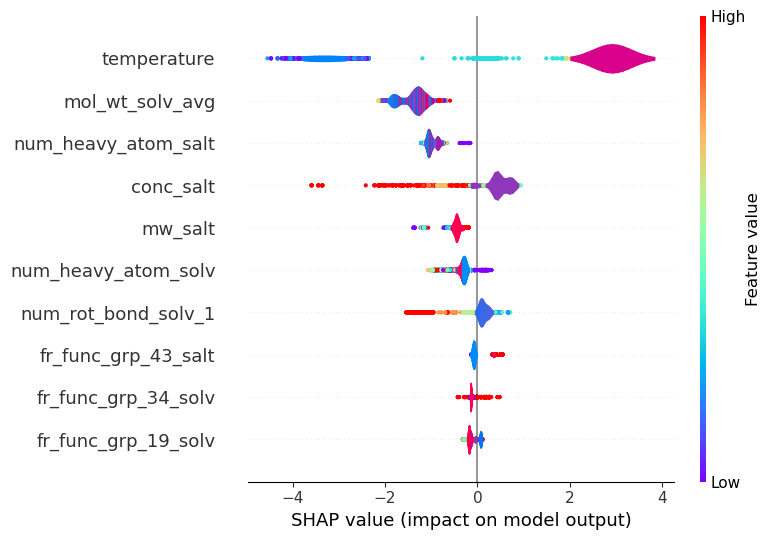

In [31]:
## original one --> colormap does not change on using violin-type plot
shap.summary_plot(shap_values, X_all, max_display=10, plot_type='violin', show=False, cmap=plt.get_cmap("rainbow"))
ax = plt.gca()
# plt.savefig('shap_lgbm_freq2.eps', bbox_inches='tight', dpi=300)
plt.savefig('shap_lgbm_feat-imp_random_new.eps', bbox_inches='tight', dpi=300)

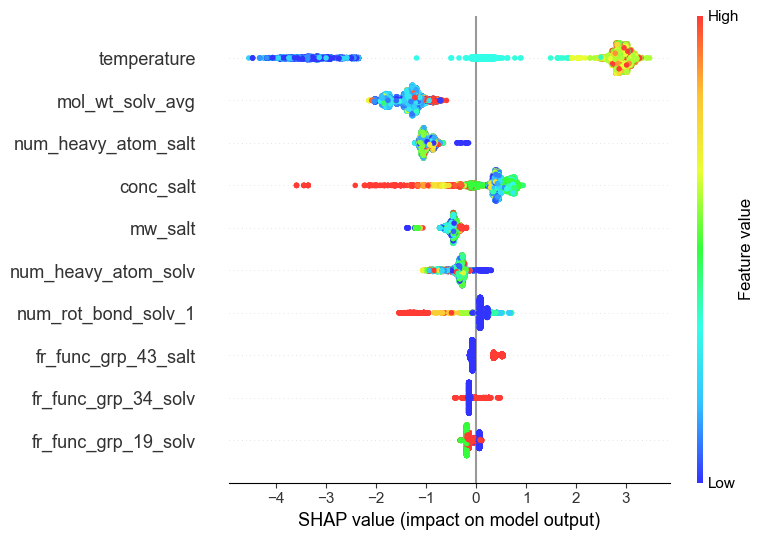

In [17]:
## Color scheme according to origin plots
c1 = '#3333FF'; c1 = matplotlib.colors.to_rgb(c1)
c2 = '#33C2FF'; c2 = matplotlib.colors.to_rgb(c2)
c3 = '#33FFE8'; c3 = matplotlib.colors.to_rgb(c3)
c4 = '#33FF3B'; c4 = matplotlib.colors.to_rgb(c4)
c5 = '#E9FF33'; c5 = matplotlib.colors.to_rgb(c5)
c6 = '#FFC133'; c6 = matplotlib.colors.to_rgb(c6)
c7 = '#FF3B33'; c7 = matplotlib.colors.to_rgb(c7)
cmap1_or = matplotlib.colors.LinearSegmentedColormap.from_list("", [c7,c6,c5,c4,c3,c2,c1]) ## from red to blue
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", [c1,c2,c3,c4,c5,c6,c7]) ## from blue to red
# shap.summary_plot(shap_values, X_all, max_display=10, plot_type='violin', show=False, cmap=cmap1)
shap.summary_plot(shap_values, X_all, max_display=10, show=False, cmap=cmap1)
ax = plt.gca()
# plt.savefig('shap_lgbm_feat-imp_random_new_origin.eps', bbox_inches='tight', dpi=300)
plt.savefig('shap_lgbm_feat-imp_random_new_inversecmap.eps', bbox_inches='tight', dpi=300)
# plt.savefig('shap_lgbm_feat-imp_random_new_origin.tiff', bbox_inches='tight', dpi=600)

In [18]:
%%bash
open .

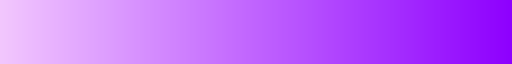

In [20]:
cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", [(0.95, 0.78, 0.996),(0.557, 0, 0.998)])
cmap2

In [22]:
matplotlib.colors.to_rgb('#3333FF')

(0.2, 0.2, 1.0)

**For temperature**

In [40]:
shap.__path__

['/Users/riteshkumar/codes/miniforge/lib/python3.9/site-packages/shap']

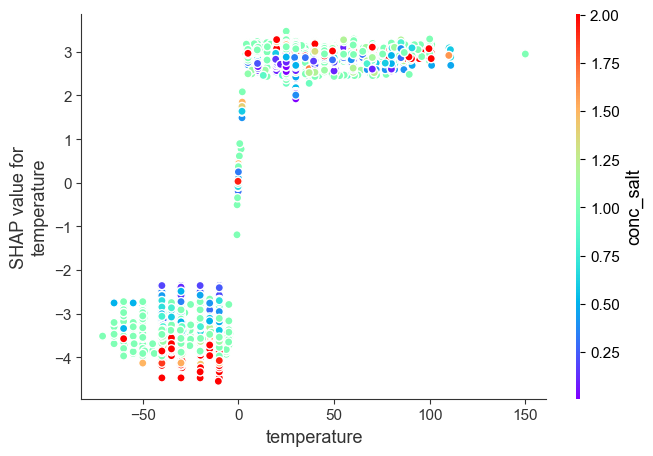

In [14]:
shap.dependence_plot('temperature', shap_values, X_all, show=False, cmap=plt.get_cmap("rainbow"), dot_size=35)
ax = plt.gca()
# plt.savefig('shap_lgbm_freq2.eps', bbox_inches='tight', dpi=300)
# plt.savefig('shap_lgbm_1.eps', bbox_inches='tight', dpi=300)

<AxesSubplot:xlabel='temperature', ylabel='temperature'>

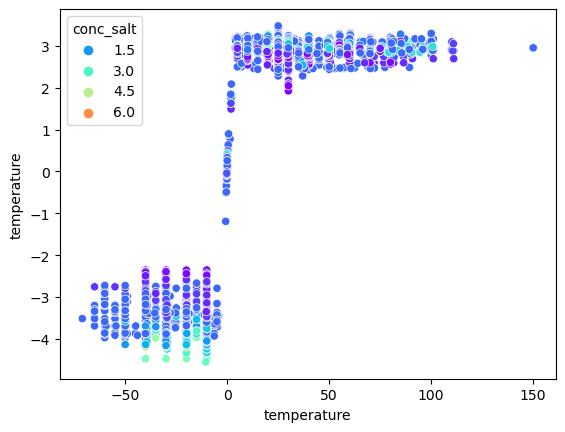

In [12]:
sns.scatterplot(X_all['temperature'], shap_df['temperature'], hue=df_all['conc_salt'], palette='rainbow')
# ax.scatter(X_all['temperature'], shap_df['temperature'], color=df_all['conc_salt'], palette='rainbow') ## not working with
# sns.scatterplot(X_all['temperature'], shap_df['temperature'], hue=df_all['conc_salt'], size=df_all['mol_wt_solv_avg'], palette='rainbow')

**For salt conc**

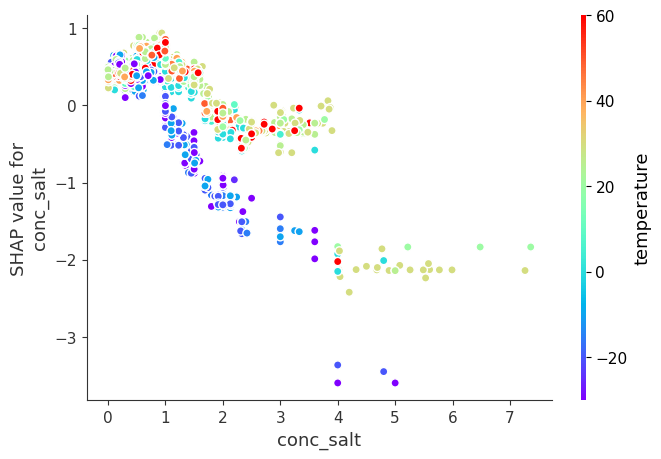

In [16]:
shap.dependence_plot('conc_salt', shap_values, X_all, show=False, cmap=plt.get_cmap("rainbow"), dot_size=35)
ax = plt.gca()
# plt.savefig('shap_lgbm_freq2.eps', bbox_inches='tight', dpi=300)
plt.savefig('shap_lgbm_2.eps', bbox_inches='tight', dpi=300)

<AxesSubplot:xlabel='conc_salt', ylabel='conc_salt'>

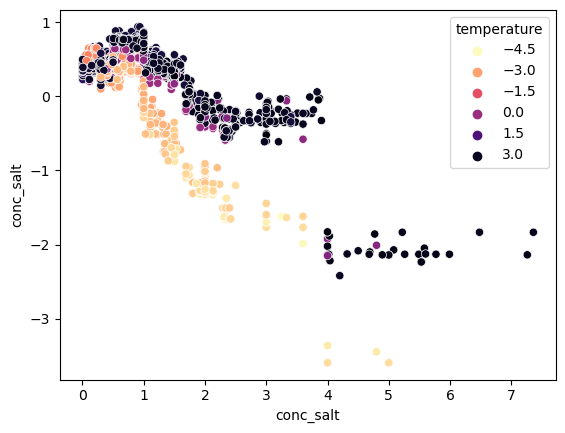

In [20]:
sns.scatterplot(X_all['conc_salt'], shap_df['conc_salt'], hue=shap_df['temperature'], palette='magma_r')

<ErrorbarContainer object of 3 artists>

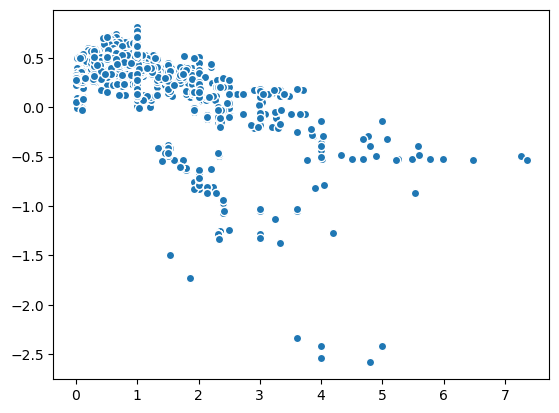

In [45]:
plt.errorbar(X_all['conc_salt'], shap_df['conc_salt'], marker='o', markeredgecolor='w', linewidth=0)

In [47]:
# high_temp_opt_conc_ind = []
opt_temp_ind = []
low_temp_ind = []
high_temp_ind = []
temp_type = []
for i in range(len(X_all)):
    # if (X_all['temperature'][i] > 0.0 and X_all['temperature'][i] < 60.0) and X_all['conc_salt'][i] == 1.0:
    if (X_all['temperature'][i] >= 20.0 and X_all['temperature'][i] <= 30.0):
        # print(X_all['temperature'][i],X_all['conc_salt'][i])
        opt_temp_ind.append(i)
        temp_type.append('20-30 $\degree$C')
    elif X_all['temperature'][i] < 20.0:
        low_temp_ind.append(i)
        temp_type.append('<20 $\degree$C')
    elif X_all['temperature'][i] > 30.0:
        high_temp_ind.append(i)
        temp_type.append('>30 $\degree$C')

In [22]:
X_conc_1 = X_all.loc[opt_temp_ind]
X_conc_2 = X_all.loc[low_temp_ind]
shap_conc_1 = shap_df.loc[opt_temp_ind]
shap_conc_2 = shap_df.loc[low_temp_ind]

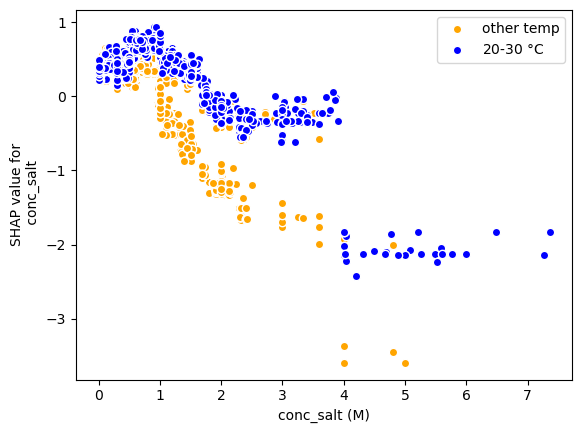

In [23]:
## Using plt.errorbar: do not use this!!!
plt.errorbar(X_conc_2['conc_salt'], shap_conc_2['conc_salt'], marker='o', markeredgecolor='w', linewidth=0, color='orange', label='other temp')
plt.errorbar(X_conc_1['conc_salt'], shap_conc_1['conc_salt'], marker='o', markeredgecolor='w', linewidth=0, color='blue', label='20-30 $\degree$C')
plt.xlabel('conc_salt (M)')
plt.ylabel('SHAP value for\n conc_salt')
plt.legend()
# plt.errorbar(X_all['conc_salt'], shap_df['conc_salt'], marker='o', markeredgecolor='w', linewidth=0, color='cyan')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


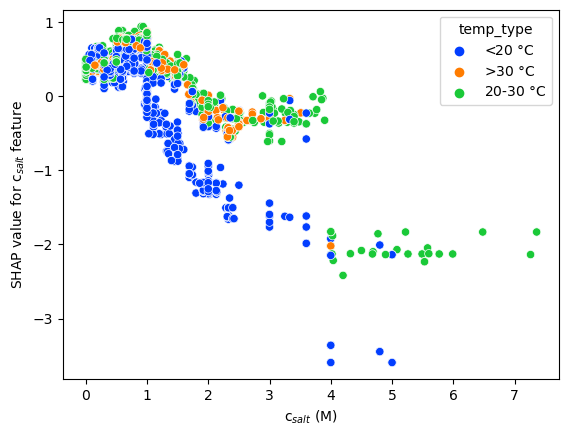

In [49]:
## Using sns.scatterplot: recommended!!!
shap_df['temp_type'] = temp_type
sns.scatterplot(X_all['conc_salt'], shap_df['conc_salt'], hue=shap_df['temp_type'], palette='bright')
plt.ylabel('SHAP value for c$_{salt}$ feature')
plt.xlabel('c$_{salt}$ (M)')
plt.savefig('shap_lgbm_3.eps', bbox_inches='tight', dpi=300)

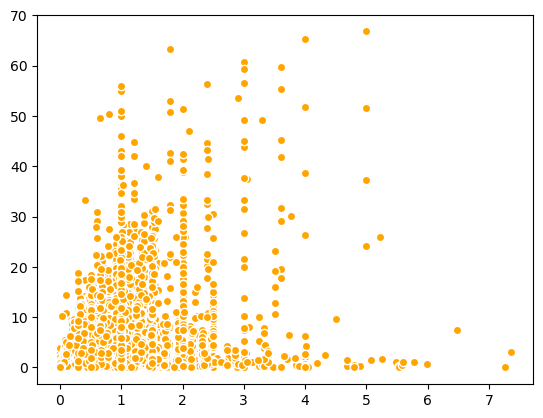

In [35]:
# plt.errorbar(df_all['conc_salt'], np.exp(df_all['conductivity_log']), marker='o', markeredgecolor='w', linewidth=0, color='orange', label='other temp')
plt.plot(df_all['conc_salt'], np.exp(df_all['conductivity_log']), marker='o', markeredgecolor='w', linewidth=0, color='orange', label='other temp')

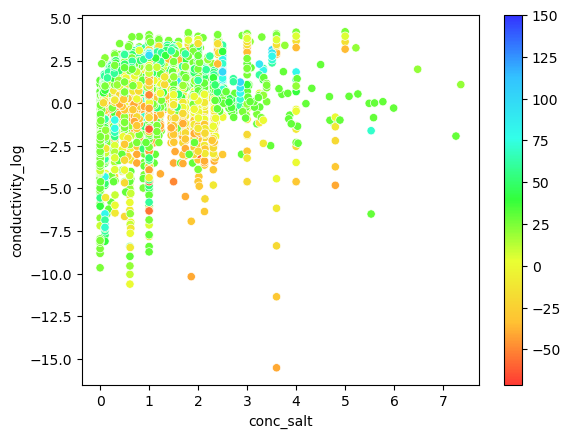

In [42]:
## this plot finally used in the supplemetary figure -- opposite colormap (not used)
ax = sns.scatterplot(x='conc_salt', y='conductivity_log', data=df_all, hue='temperature', palette=cmap1)
# cbar = plt.colorbar(fig)
# cbar.set_label('Temperature ($\degree$C)', rotation=270, labelpad=15)
norm = plt.Normalize(df_all['temperature'].min(), df_all['temperature'].max())
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)
plt.savefig('conc_salt_actual_log.eps', bbox_inches='tight', dpi=300)

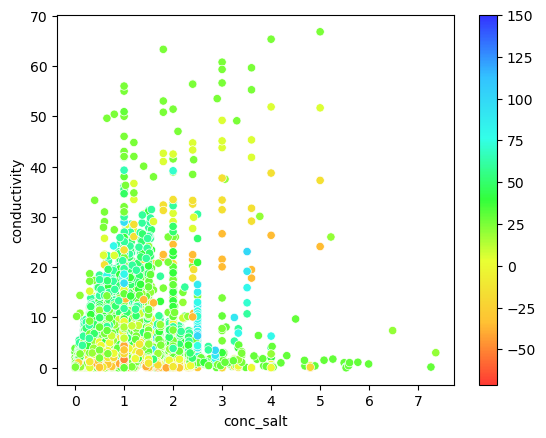

In [43]:
## this plot used finally in supplementary figure -- opposite colormap (not used)
df_all['conductivity'] = np.exp(df_all['conductivity_log'])
ax = sns.scatterplot(x='conc_salt', y='conductivity', data=df_all, hue='temperature', palette=cmap1)

norm = plt.Normalize(df_all['temperature'].min(), df_all['temperature'].max())
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)
plt.savefig('conc_salt_actual_normal.eps', bbox_inches='tight', dpi=300)

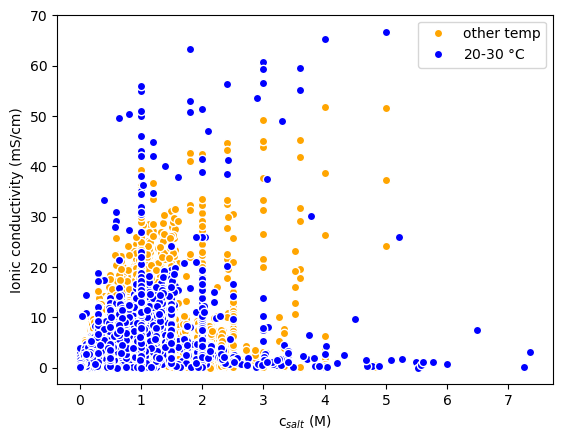

In [35]:
plt.errorbar(df_all['conc_salt'].loc[low_temp_ind], np.exp(df_all['conductivity_log'].loc[low_temp_ind]), marker='o', markeredgecolor='w', linewidth=0, color='orange', label='other temp')
plt.errorbar(df_all['conc_salt'].loc[opt_temp_ind], np.exp(df_all['conductivity_log'].loc[opt_temp_ind]), marker='o', markeredgecolor='w', linewidth=0, color='blue', label='20-30 $\degree$C')
plt.xlabel('c$_{salt}$ (M)')
plt.ylabel('Ionic conductivity (mS/cm)')
plt.legend()

In [68]:
df_all.loc[df_all['conc_salt'] > 5.0]

,solv_comb_sm,salt_smiles,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,...,fr_func_grp_41_salt,fr_func_grp_42_salt,fr_func_grp_43_salt,num_heavy_atom_salt,num_rot_bond_salt,mw_salt,conc_salt,temperature,mol_wt_solv_avg,conductivity_log
522,COC(=O)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0,0,0,0,0,0,0,0,...,0,0,0,10,2,179.924229,5.490,30.0,90.031694,0.000000
1228,COCCOCCOCCOC,[Li+].O=S1(=O)[N-]S(=O)(=O)C(F)(F)C1(F)F,0,0,0,0,0,0,0,0,...,0,0,0,14,0,241.921036,5.530,70.0,178.120509,-1.609438
1974,CC#N.O=c1occo1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0,2,0,0,0,0,0,0,...,0,0,0,10,2,179.924229,6.480,20.0,45.115080,2.001480
3618,COCCOCCOCCOC,[Li+].O=S1(=O)[N-]S(=O)(=O)C(F)(F)C1(F)F,0,0,0,0,0,0,0,0,...,0,0,0,14,0,241.921036,5.530,30.0,178.120509,-6.502290
4302,CC(=O)CC(=O)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0,0,0,0,0,0,0,0,...,0,0,0,10,2,179.924229,5.080,30.0,116.047344,0.412110
5029,CC1COC(=O)O1,[Li+].[B-](F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,6,0,87.003467,7.261,30.0,102.031694,-1.924937
5728,COC(=O)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0,0,0,0,0,0,0,0,...,0,0,0,10,2,179.924229,5.260,30.0,90.031694,0.548121
6602,CC(=O)C(=O)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0,0,0,0,0,0,0,0,...,0,0,0,10,2,179.924229,5.580,30.0,102.031694,-0.843970
8711,CC#N.O=c1occo1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0,2,0,0,0,0,0,0,...,0,0,0,10,2,179.924229,5.220,20.0,45.115080,3.258097
9111,CC#N.O=c1occo1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0,2,0,0,0,0,0,0,...,0,0,0,10,2,179.924229,7.360,20.0,45.115080,1.098612


**For temp**

Text(0, 0.5, 'Ionic conductivity (mS/cm)')

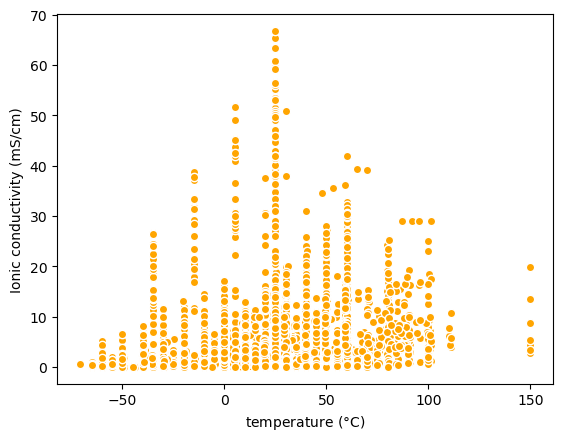

In [71]:
plt.errorbar(df_all['temperature'], np.exp(df_all['conductivity_log']), marker='o', markeredgecolor='w', linewidth=0, color='orange', label='other temp')
plt.xlabel('temperature ($\degree$C)')
plt.ylabel('Ionic conductivity (mS/cm)')
# plt.legend()

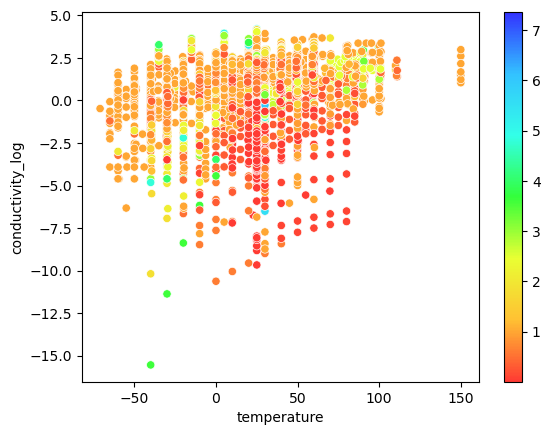

In [37]:
## this plot finally used in the supplemetary figure -- opposite colormap (not used)
ax = sns.scatterplot(x='temperature', y='conductivity_log', data=df_all, hue='conc_salt', palette=cmap1)
norm = plt.Normalize(df_all['conc_salt'].min(), df_all['conc_salt'].max())
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)
plt.savefig('temperature_actual_log.eps', bbox_inches='tight', dpi=300)

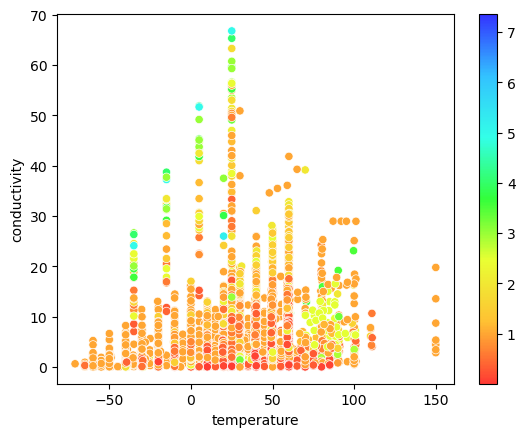

In [38]:
## this plot finally used in the supplemetary figure -- opposite colormap (not used)
ax = sns.scatterplot(x='temperature', y='conductivity', data=df_all, hue='conc_salt', palette=cmap1)
norm = plt.Normalize(df_all['conc_salt'].min(), df_all['conc_salt'].max())
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)
plt.savefig('temperature_actual_normal.eps', bbox_inches='tight', dpi=300)

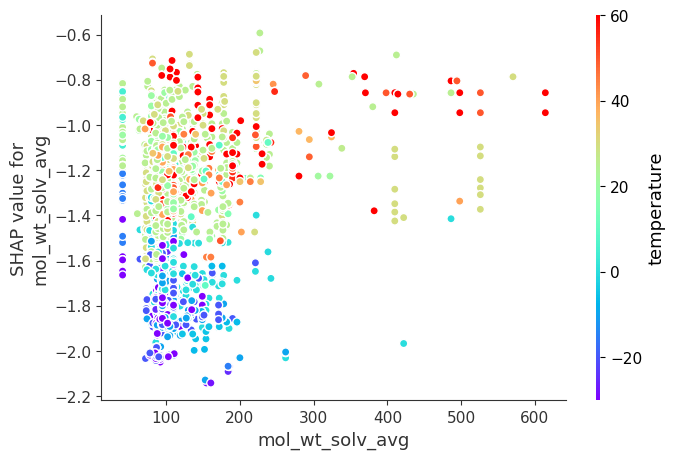

In [19]:
shap.dependence_plot('mol_wt_solv_avg', shap_values, X_all, cmap=plt.get_cmap("rainbow"), dot_size=35)
# shap.dependence_plot('mol_wt_solv_avg', shap_values, X_all, cmap=sns.color_palette('hls'))

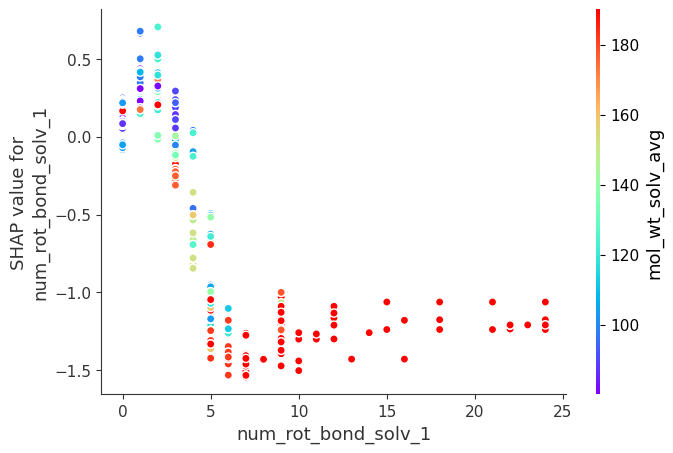

In [58]:
shap.dependence_plot('num_rot_bond_solv_1', shap_values, X_all, cmap=plt.get_cmap("rainbow"), dot_size=35, interaction_index='mol_wt_solv_avg')

**Replot general salt conc & temperature plots according to color scheme: added on 14th Mat, 2023**

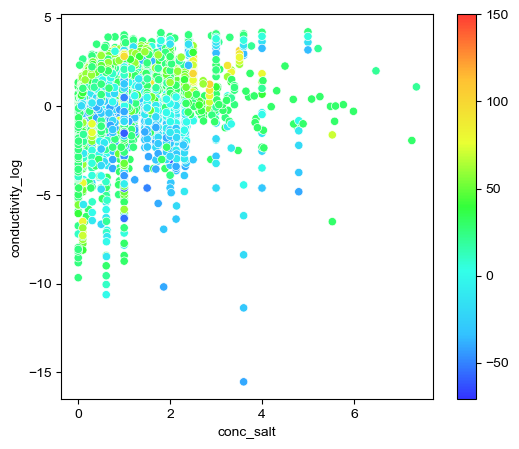

In [22]:
## For conc_salt: this plot finally used in the supplemetary figure
fig, ax = plt.subplots(figsize=(6, 5))
## Color scheme according to origin plots
c1 = '#3333FF'; c1 = matplotlib.colors.to_rgb(c1)
c2 = '#33C2FF'; c2 = matplotlib.colors.to_rgb(c2)
c3 = '#33FFE8'; c3 = matplotlib.colors.to_rgb(c3)
c4 = '#33FF3B'; c4 = matplotlib.colors.to_rgb(c4)
c5 = '#E9FF33'; c5 = matplotlib.colors.to_rgb(c5)
c6 = '#FFC133'; c6 = matplotlib.colors.to_rgb(c6)
c7 = '#FF3B33'; c7 = matplotlib.colors.to_rgb(c7)
cmap1_or = matplotlib.colors.LinearSegmentedColormap.from_list("", [c7,c6,c5,c4,c3,c2,c1]) ## from red to blue
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", [c1,c2,c3,c4,c5,c6,c7]) ## from blue to red
ax = sns.scatterplot(x='conc_salt', y='conductivity_log', data=df_all, hue='temperature', palette=cmap1)
# cbar = plt.colorbar(fig)
# cbar.set_label('Temperature ($\degree$C)', rotation=270, labelpad=15)
norm = plt.Normalize(df_all['temperature'].min(), df_all['temperature'].max())
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.set_yticks([-15, -10, -5, 0, 5])
ax.figure.colorbar(sm, ticks=[-50, 0, 50, 100, 150])
plt.savefig('conc_salt_actual_log_051423.eps', dpi=300)

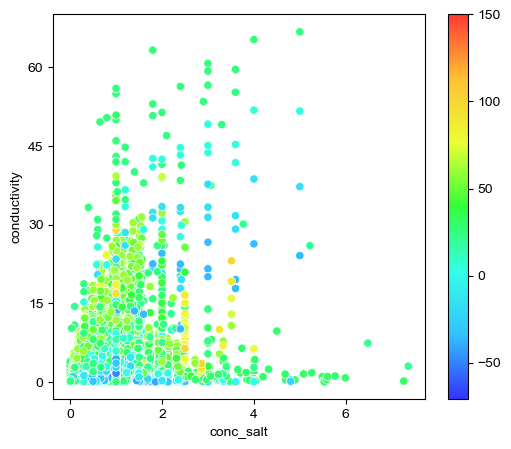

In [24]:
## For conc_salt: this plot used finally in supplementary figure
fig, ax = plt.subplots(figsize=(6, 5))
df_all['conductivity'] = np.exp(df_all['conductivity_log'])
ax = sns.scatterplot(x='conc_salt', y='conductivity', data=df_all, hue='temperature', palette=cmap1)

norm = plt.Normalize(df_all['temperature'].min(), df_all['temperature'].max())
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.set_yticks([0, 15, 30, 45, 60])
ax.figure.colorbar(sm, ticks=[-50, 0, 50, 100, 150])
plt.savefig('conc_salt_actual_normal_051423.eps', dpi=300)

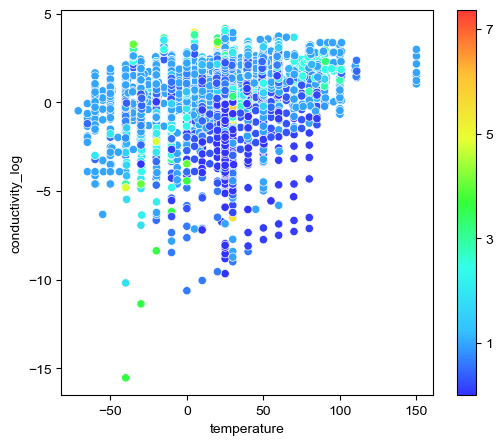

In [30]:
## For temperature: this plot finally used in the supplemetary figure
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.scatterplot(x='temperature', y='conductivity_log', data=df_all, hue='conc_salt', palette=cmap1)
norm = plt.Normalize(df_all['conc_salt'].min(), df_all['conc_salt'].max())
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.set_yticks([-15, -10, -5, 0, 5])
ax.figure.colorbar(sm, ticks=[1, 3, 5, 7])
plt.savefig('temperature_actual_log_051423.eps', bbox_inches='tight', dpi=300)

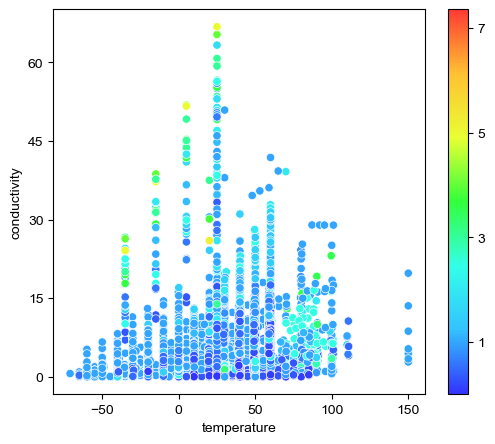

In [32]:
## For temperature: this plot finally used in the supplemetary figure
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.scatterplot(x='temperature', y='conductivity', data=df_all, hue='conc_salt', palette=cmap1)
norm = plt.Normalize(df_all['conc_salt'].min(), df_all['conc_salt'].max())
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.set_yticks([0, 15, 30, 45, 60])
ax.figure.colorbar(sm, ticks=[1, 3, 5, 7])
plt.savefig('temperature_actual_normal_051423.eps', dpi=300)

In [103]:
comb_df = comb_df.sort_values(by=['conc_salt'], ascending=True)

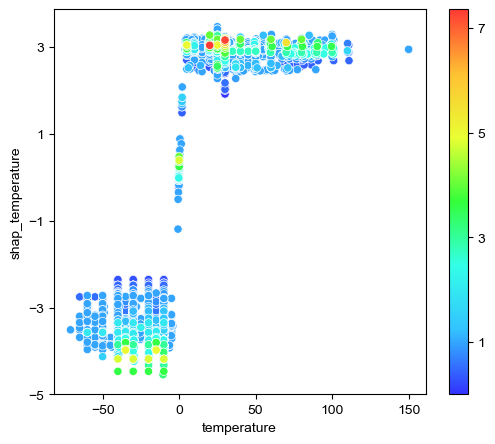

In [42]:
## Also for SHAP dependence plot: temperature (whole range)
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.scatterplot(x='temperature', y='shap_temperature', data=comb_df, hue='conc_salt', palette=cmap1)
norm = plt.Normalize(df_all['conc_salt'].min(), df_all['conc_salt'].max())
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.set_yticks([-5, -3, -1, 1, 3])
ax.figure.colorbar(sm, ticks=[1, 3, 5, 7])
plt.savefig('shap_temperature_complete_051423.eps', dpi=300)

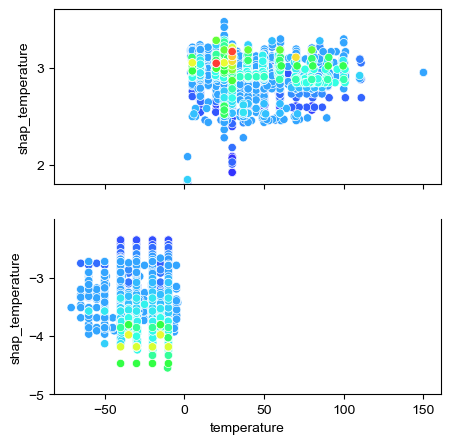

In [128]:
"""Add an y-axis break in the above SHAP dependence plot for temperature in the y-axis from -1 to 1"""
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 5))
ax1 = sns.scatterplot(x='temperature', y='shap_temperature', data=comb_df, hue='conc_salt', palette=cmap1, ax=ax1)
ax2 = sns.scatterplot(x='temperature', y='shap_temperature', data=comb_df, hue='conc_salt', palette=cmap1, ax=ax2)
# ax1.set_ylim(1, 3.7)
# ax2.set_ylim(-5, -1)
ax1.set_ylim(1.8, 3.6)
ax2.set_ylim(-5, -2)

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
# kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
# ax.plot((1-d, 1+d), (-d, +d), **kwargs)
# ax.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

# kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
# ax2.plot((-d, +d), (1-d, 1+d), **kwargs)
# ax2.plot((-d, +d), (-d, +d), **kwargs)

ax1.get_legend().remove()
ax2.get_legend().remove()
ax1.set_yticks([2, 3])
ax2.set_yticks([-5, -4, -3])
# ax1.figure.colorbar(sm, ticks=[1, 3, 5, 7])
# ax2.figure.colorbar(sm, ticks=[1, 3, 5, 7])
# plt.savefig('shap_temperature_complete_break_051623.eps', dpi=300)

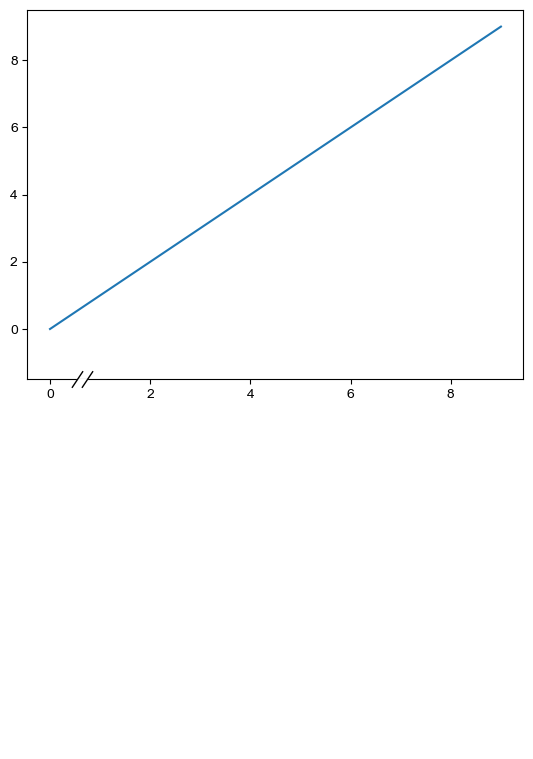

In [117]:
from matplotlib.patches import Rectangle

def axis_break(axis, xpos=[0.1, 0.125], slant=1.5):
    d = slant  # proportion of vertical to horizontal extent of the slanted line
    anchor = (xpos[0], -1)
    w = xpos[1] - xpos[0]
    h = 1

    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, zorder=3,
                linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    axis.add_patch(Rectangle(
        anchor, w, h, fill=True, color="white",
        transform=axis.transAxes, clip_on=False, zorder=3)
    )
    axis.plot(xpos, [0, 0], transform=axis.transAxes, **kwargs)

def axis_break_(axis, ypos=[0.1, 0.125], slant=1.5):
    d = slant  # proportion of vertical to horizontal extent of the slanted line
    anchor = (-1, ypos[0])
    h = ypos[1] - ypos[0]
    w = 1

    kwargs = dict(marker=[(1, d), (-1, -d)], markersize=12, zorder=3,
                linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    axis.add_patch(Rectangle(
        anchor, w, h, fill=True, color="white",
        transform=axis.transAxes, clip_on=False, zorder=3)
    )
    axis.plot(ypos, [0, 0], transform=axis.transAxes, **kwargs)

fig, ax = plt.subplots(1,1)
plt.plot(np.arange(10))
axis_break(ax, xpos=[0.1, 0.12], slant=1.5)
# axis_break_(ax, ypos=[1, 3], slant=1.5)
# axis_break(ax, xpos=[0.3, 0.31], slant=-10)

In [131]:
comb_df = comb_df.sort_values(by=['temperature'], ascending=True)

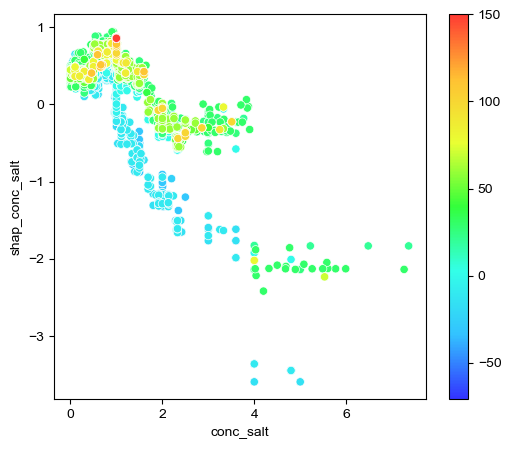

In [72]:
## Also for SHAP dependence plot: conc_salt (whole range)
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.scatterplot(x='conc_salt', y='shap_conc_salt', data=comb_df, hue='temperature', palette=cmap1)
norm = plt.Normalize(df_all['temperature'].min(), df_all['temperature'].max())
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.set_yticks([-3, -2, -1, 0, 1])
ax.figure.colorbar(sm, ticks=[-50, 0, 50, 100, 150])
plt.savefig('shap_conc_salt_complete_051423.eps', dpi=300)

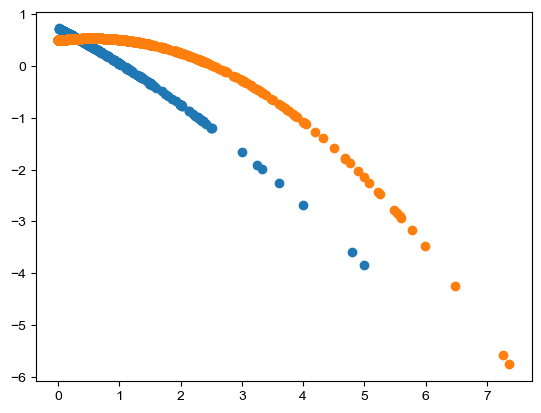

In [92]:
## trying to fit a curve to the data: 2nd degree polynomial
x_smooth = np.linspace(0,3.5,100)

x_1 = comb_df.loc[comb_df['temperature'] <= 0.0]['conc_salt']; y_1 = comb_df.loc[comb_df['temperature'] <= 0.0]['shap_conc_salt']
x_2 = comb_df.loc[comb_df['temperature'] > 0.0]['conc_salt']; y_2 = comb_df.loc[comb_df['temperature'] > 0.0]['shap_conc_salt']
coeff_1 = np.polyfit(x_1, y_1, 2)
coeff_2 = np.polyfit(x_2, y_2, 2)
x = comb_df['conc_salt']

x_1_ = np.unique(x_1); y_1_ = np.polyval(coeff_1, x_1_)
x_2_ = np.unique(x_2); y_2_ = np.polyval(coeff_2, x_2_)

plt.plot(x_1_, y_1_, 'o')
plt.plot(x_2_, y_2_, 'o')

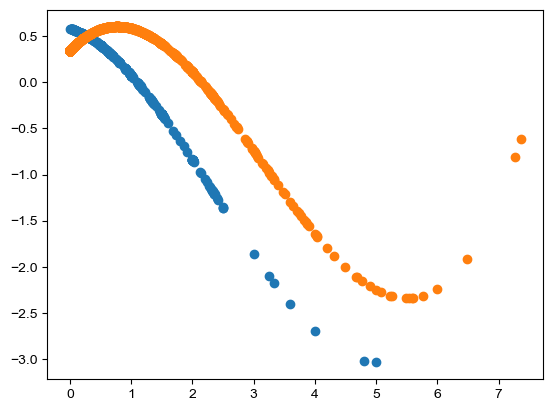

In [90]:
## trying to fit a curve to the data: 3rd degree polynomial
from scipy.interpolate import make_interp_spline
x_smooth = np.linspace(0,3.5,100)
# spline_1 = make_interp_spline(comb_df['conc_salt'], comb_df['shap_conc_salt'], k=3) ## k = 2(quadratic); k = 3(cubic); k > 3 (higher order)
# y_smooth = spline_1(x_smooth)
# plt.plot(x_smooth, y_smooth)
x_1 = comb_df.loc[comb_df['temperature'] <= 0.0]['conc_salt']; y_1 = comb_df.loc[comb_df['temperature'] <= 0.0]['shap_conc_salt']
x_2 = comb_df.loc[comb_df['temperature'] > 0.0]['conc_salt']; y_2 = comb_df.loc[comb_df['temperature'] > 0.0]['shap_conc_salt']
coeff_1 = np.polyfit(x_1, y_1, 3)
coeff_2 = np.polyfit(x_2, y_2, 3)
x = comb_df['conc_salt']

x_1_ = np.unique(x_1); y_1_ = np.polyval(coeff_1, x_1_)
x_2_ = np.unique(x_2); y_2_ = np.polyval(coeff_2, x_2_)
# y = coeff[0]*x**3 + coeff[1]*x**2 + coeff[2]*x + coeff[3]
# y_smooth_1 = coeff_1[0]*x_smooth**3 + coeff_1[1]*x_smooth**2 + coeff_1[2]*x_smooth + coeff_1[3]
# y_smooth_2 = coeff_2[0]*x_smooth**3 + coeff_2[1]*x_smooth**2 + coeff_2[2]*x_smooth + coeff_2[3]
# plt.plot(x_smooth, y_smooth_1)
# plt.plot(x_smooth, y_smooth_2)
plt.plot(x_1_, y_1_, 'o')
plt.plot(x_2_, y_2_, 'o')

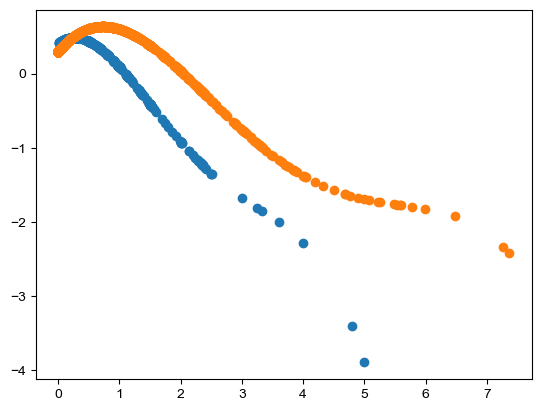

In [85]:
## trying to fit a curve to the data: 4th degree polynomial
x_smooth = np.linspace(0,3.5,500)

x_1 = comb_df.loc[comb_df['temperature'] <= 0.0]['conc_salt']; y_1 = comb_df.loc[comb_df['temperature'] <= 0.0]['shap_conc_salt']
x_2 = comb_df.loc[comb_df['temperature'] > 0.0]['conc_salt']; y_2 = comb_df.loc[comb_df['temperature'] > 0.0]['shap_conc_salt']
coeff_1 = np.polyfit(x_1, y_1, 4)
coeff_2 = np.polyfit(x_2, y_2, 4)
x = comb_df['conc_salt']

x_1_ = np.unique(x_1); y_1_ = np.polyval(coeff_1, x_1_) ## this seems to be correct way to plot fitted data
x_2_ = np.unique(x_2); y_2_ = np.polyval(coeff_2, x_2_)
# y_smooth_1 = coeff_1[0]*x_smooth**4 + coeff_1[1]*x_smooth**3 + coeff_1[2]*x_smooth**2 + coeff_1[3]**x_smooth + coeff_1[4]
# y_smooth_2 = coeff_2[0]*x_smooth**4 + coeff_2[1]*x_smooth**3 + coeff_2[2]*x_smooth**2 + coeff_2[3]**x_smooth + coeff_2[4]
# plt.plot(x_smooth, y_smooth_1)
# plt.plot(x_smooth, y_smooth_2)
plt.plot(x_1_, y_1_, 'o')
plt.plot(x_2_, y_2_, 'o')

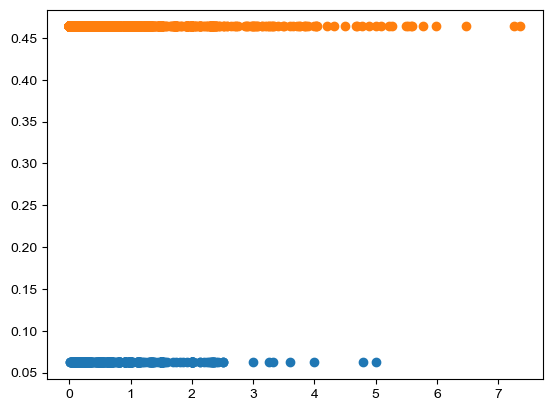

In [83]:
## trying to fit a curve to the data: 1/2 degree polynomial
x_smooth = np.linspace(0,3.5,500)

x_1 = comb_df.loc[comb_df['temperature'] <= 0.0]['conc_salt']; y_1 = comb_df.loc[comb_df['temperature'] <= 0.0]['shap_conc_salt']
x_2 = comb_df.loc[comb_df['temperature'] > 0.0]['conc_salt']; y_2 = comb_df.loc[comb_df['temperature'] > 0.0]['shap_conc_salt']
coeff_1 = np.polyfit(x_1, y_1, 0.5)
coeff_2 = np.polyfit(x_2, y_2, 0.5)
x = comb_df['conc_salt']

x_1_ = np.unique(x_1); y_1_ = np.polyval(coeff_1, x_1_) ## this seems to be correct way to plot fitted data
x_2_ = np.unique(x_2); y_2_ = np.polyval(coeff_2, x_2_)

plt.plot(x_1_, y_1_, 'o')
plt.plot(x_2_, y_2_, 'o')

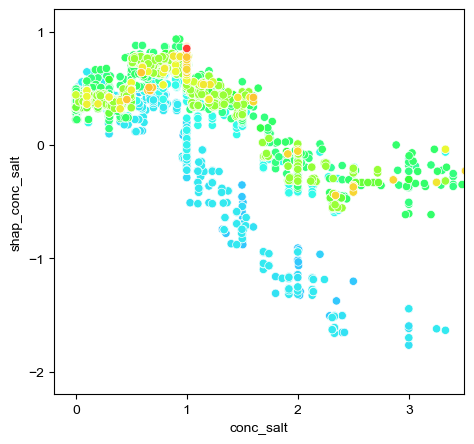

In [143]:
## Also for SHAP dependence plot: conc_salt (reduced range)
fig, ax = plt.subplots(figsize=(5.3, 5))
ax = sns.scatterplot(x='conc_salt', y='shap_conc_salt', data=comb_df, hue='temperature', palette=cmap1)
norm = plt.Normalize(df_all['temperature'].min(), df_all['temperature'].max())
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
sm.set_array([])

# plt.plot(x_smooth, y_smooth_1, color='black', linewidth=2) ## don't use it
# plt.plot(x_smooth, y_smooth_2, color='gray', linewidth=2) 

# plt.plot(x_1_, y_1_, color=c1, linewidth=2, linestyle='--') ## from 3rd degree polynomial fit (not using it)
# plt.plot(x_2_, y_2_, color=c7, linewidth=2, linestyle='--') 

# plt.plot(x_1_, y_1_, color=c1, linewidth=2, linestyle='--') ## from 4th degree polynomial fit
# plt.plot(x_2_, y_2_, color=c7, linewidth=2, linestyle='--')
# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.set_xlim([-0.2, 3.5])
ax.set_ylim([-2.2, 1.2])
ax.set_yticks([-2, -1, 0, 1])
ax.set_xticks([0, 1, 2, 3])
# ax.figure.colorbar(sm, ticks=[-50, 0, 50, 100, 150]) ## turn off to match size with temperature subplot
plt.savefig('shap_conc_salt_reduced_051423.eps', dpi=300)

In [141]:
%%bash
open .

**SHAP force & waterfalls plots: not used in paper!!!**

In [34]:
shap.initjs()

In [22]:
shap.force_plot(explainerModel.expected_value, shap_values[0], X_all.iloc[[0]])

In [23]:
shap.force_plot(explainerModel.expected_value, shap_values[1228], X_all.iloc[[1228]])

In [24]:
shap.force_plot(explainerModel.expected_value, shap_values[3618], X_all.iloc[[3618]])

In [25]:
shap.force_plot(explainerModel.expected_value, shap_values[522], X_all.iloc[[522]])

In [26]:
shap.force_plot(explainerModel.expected_value, shap_values[5029], X_all.iloc[[5029]])

In [89]:
shap_force = explainerModel.shap_values(X_train_std)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


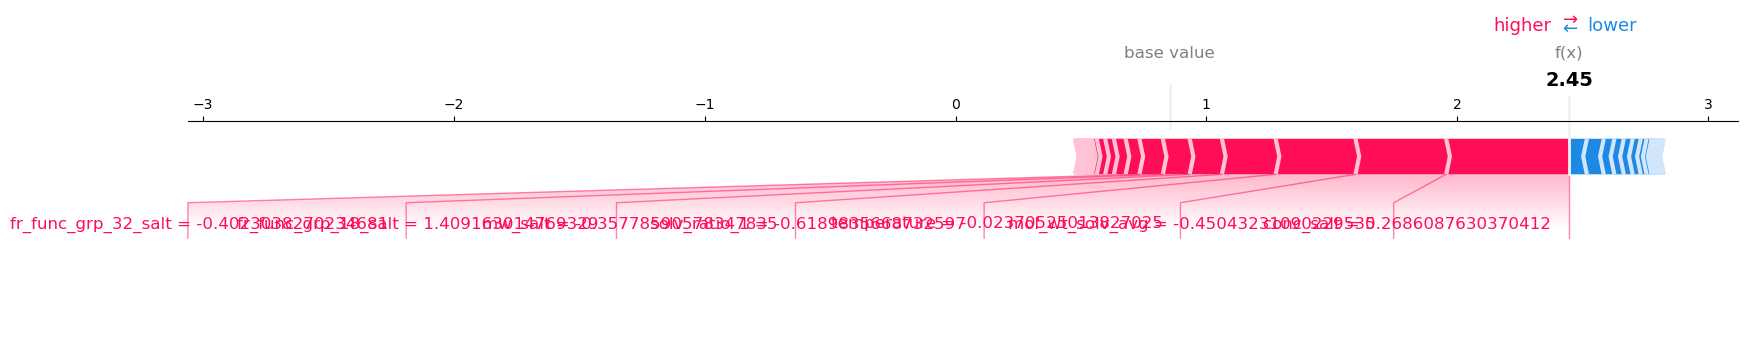

In [107]:
shap.force_plot(explainerModel.expected_value, shap_force[353], X_train_std.iloc[[353]], show=False, matplotlib=True)
# ax = plt.gca()
plt.savefig('force_lgbm_cond_ec_dmc.eps', bbox_inches='tight', dpi=300)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


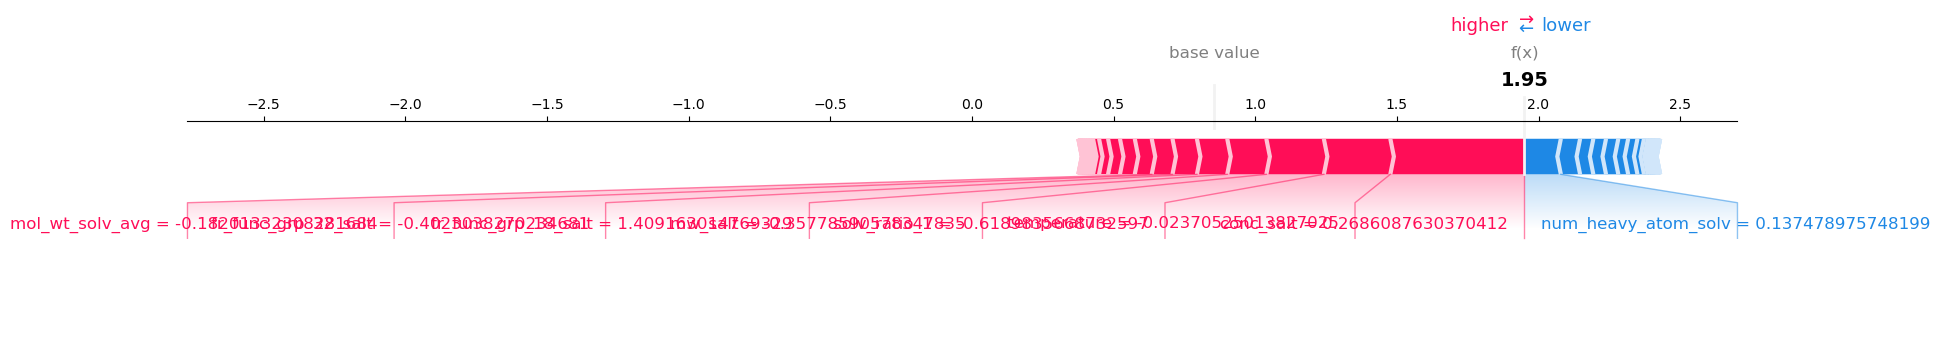

In [108]:
# feat_name = ['conc_salt', 'mol_wt_solv_avg', 'temperature', 'solv_ratio_1', 'mw_salt', 'fr_func_grp_18_salt', 'fr_func_grp_10_solv']
# shap.force_plot(explainerModel.expected_value, shap_force[1124], X_train_std.iloc[[1124]], feature_names=feat_name)
shap.force_plot(explainerModel.expected_value, shap_force[1124], X_train_std.iloc[[1124]], show=False, matplotlib=True)
# ax = plt.gca()
plt.savefig('force_lgbm_cond_ec_dec.eps', bbox_inches='tight', dpi=300)
plt.show()

In [94]:
shap_force.shape

(8166, 100)

**Waterfall plot**

In [61]:
## solvent = EC-DMC; salt = LiPF6
# df_all.loc[df_all['solv_comb_sm'] == 'O=C1OCCO1.COC(=O)OC']
train_df.loc[train_df['solv_comb_sm'] == 'O=C1OCCO1.COC(=O)OC'].loc[train_df['salt_smiles'] == '[Li+].F[P-](F)(F)(F)(F)F'].loc[train_df['temperature'] == 20.000]

,solv_comb_sm,salt_smiles,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,...,fr_func_grp_41_salt,fr_func_grp_42_salt,fr_func_grp_43_salt,num_heavy_atom_salt,num_rot_bond_salt,mw_salt,conc_salt,temperature,mol_wt_solv_avg,conductivity_log
12,O=C1OCCO1.COC(=O)OC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,144.964181,0.500,20.0,89.023869,2.238580
349,O=C1OCCO1.COC(=O)OC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,144.964181,1.000,20.0,89.023869,2.397895
353,O=C1OCCO1.COC(=O)OC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,144.964181,1.000,20.0,89.023869,2.302585
581,O=C1OCCO1.COC(=O)OC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,144.964181,1.500,20.0,89.023869,2.360854
684,O=C1OCCO1.COC(=O)OC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,144.964181,0.787,20.0,89.023869,2.367436
771,O=C1OCCO1.COC(=O)OC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,144.964181,2.000,20.0,89.023869,2.238580
2152,O=C1OCCO1.COC(=O)OC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,144.964181,1.000,20.0,89.023869,2.410542


In [62]:
## solvent = EC-DEC; salt = LiPF6
train_df.loc[train_df['solv_comb_sm'] == 'O=C1OCCO1.CCOC(=O)OCC'].loc[train_df['salt_smiles'] == '[Li+].F[P-](F)(F)(F)(F)F'].loc[train_df['temperature'] == 20.000]

,solv_comb_sm,salt_smiles,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,...,fr_func_grp_41_salt,fr_func_grp_42_salt,fr_func_grp_43_salt,num_heavy_atom_salt,num_rot_bond_salt,mw_salt,conc_salt,temperature,mol_wt_solv_avg,conductivity_log
1124,O=C1OCCO1.CCOC(=O)OCC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,144.964181,1.0,20.0,103.039519,1.88813


In [63]:
print(train_df['solv_ratio_1'][349], train_df['solv_ratio_2'][349], train_df['solv_comb_sm'][349])
print(train_df['solv_ratio_1'][353], train_df['solv_ratio_2'][353], train_df['solv_comb_sm'][353])
print(train_df['solv_ratio_1'][2152], train_df['solv_ratio_2'][2152], train_df['solv_comb_sm'][2152])
print(train_df['solv_ratio_1'][1124], train_df['solv_ratio_2'][1124], train_df['solv_comb_sm'][1124])

0.952380952 0.047619048 O=C1OCCO1.COC(=O)OC
0.5 0.5 O=C1OCCO1.COC(=O)OC
0.3 0.7 O=C1OCCO1.COC(=O)OC
0.5 0.5 O=C1OCCO1.CCOC(=O)OCC


In [76]:
explainer = shap.Explainer(lgb)
shap_value = explainer(X_train_std)

In [68]:
y_pred_train[5029]

-1.2831608848603926

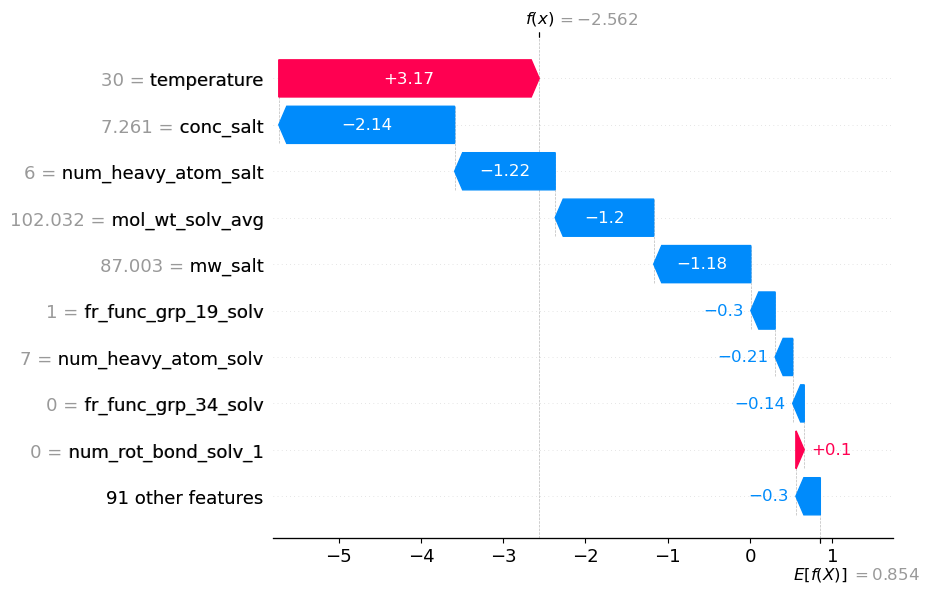

In [65]:
shap.plots.waterfall(shap_value[5029])

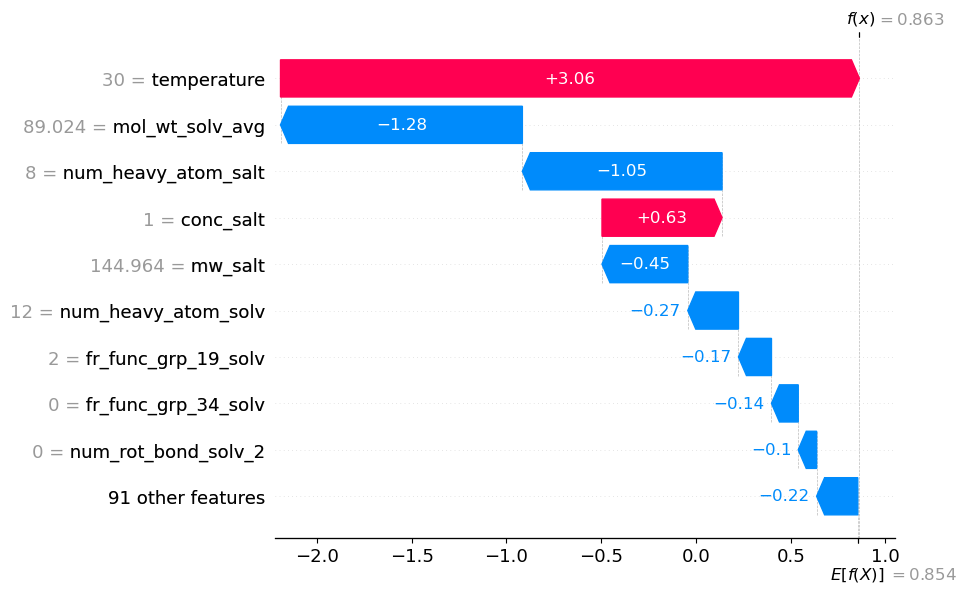

In [66]:
shap.plots.waterfall(shap_value[571])

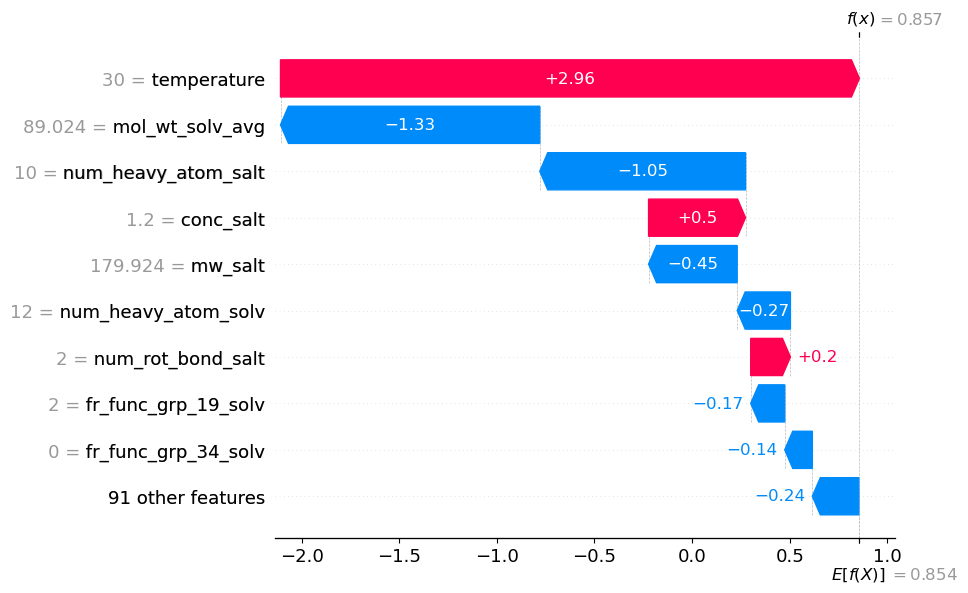

In [67]:
shap.plots.waterfall(shap_value[4585])

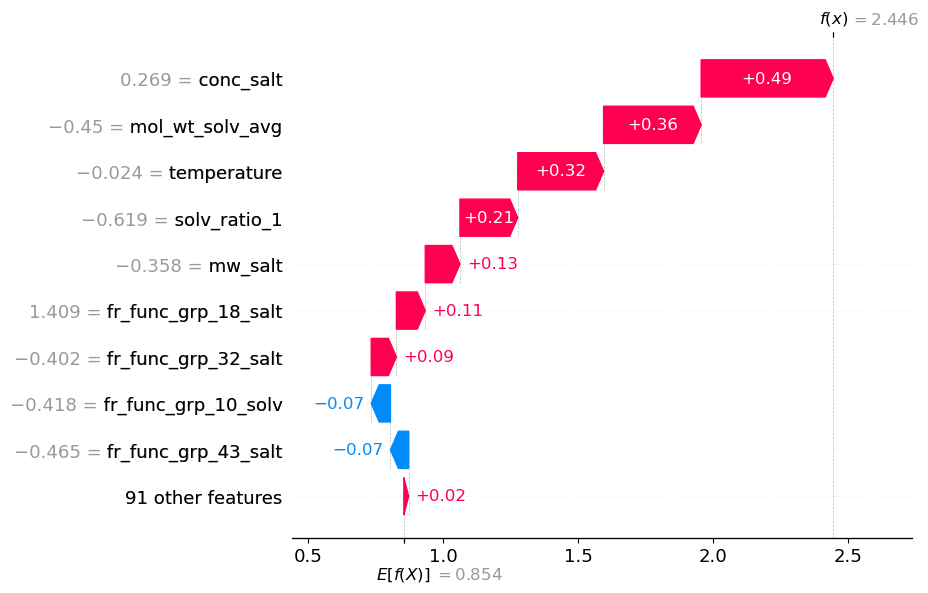

In [82]:
shap.plots.waterfall(shap_value[353], show=False)
ax = plt.gca()
plt.savefig('waterfall_lgbm_cond_ec_dmc.eps', bbox_inches='tight', dpi=300)
plt.show()

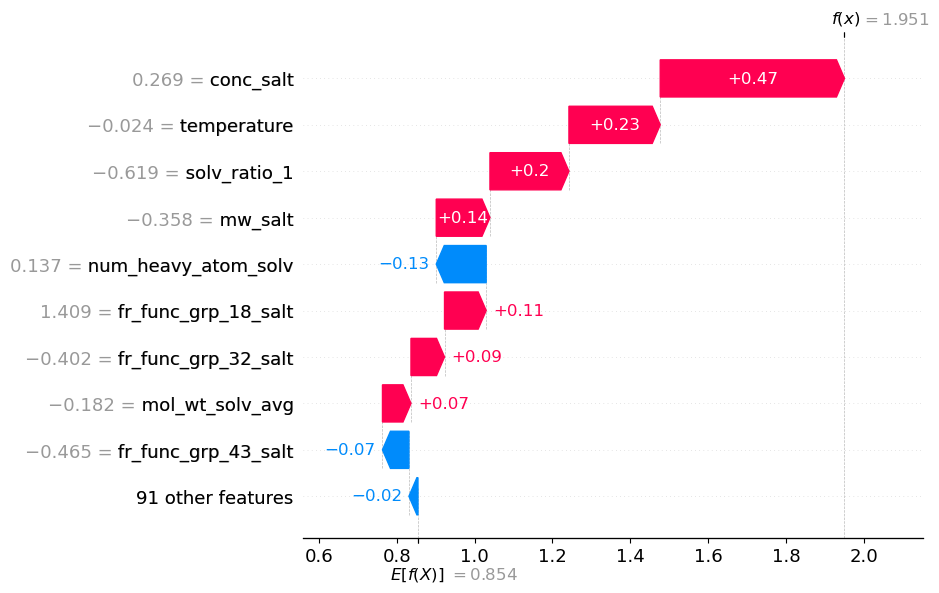

In [81]:
shap.plots.waterfall(shap_value[1124], show=False)
ax = plt.gca()
plt.savefig('waterfall_lgbm_cond_ec_dec.eps', bbox_inches='tight', dpi=300)
plt.show()

In [55]:
y_pred_train[1124]

1.9505214765726844

In [60]:
y_pred_train[353]

2.4459849186516296

In [15]:
sns.color_palette('hls')

[(0.86, 0.3712, 0.33999999999999997),
 (0.8287999999999999, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.3712),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.3712, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.8287999999999999)]